# Using Pre-trained Video Models as Reward Functions

In this notebook we will examine the effectiveness of VIPER when used as a reward model. We will examine video model log likelihoods to determine how correlated they are with the task reward.

In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.dirname(os.path.abspath("")))

import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import notebook_utils as nbu
from videogpt.reward_models import LOAD_REWARD_MODEL_DICT

print('Available reward models:', LOAD_REWARD_MODEL_DICT.keys())

Available reward models: dict_keys(['dmc_clen16_fskip1', 'dmc_clen16_fskip2', 'dmc_clen16_fskip4'])


In [38]:
# Load reward model.
rm_key = 'dmc_clen16_fskip4'
reward_model = LOAD_REWARD_MODEL_DICT[rm_key](task='dmc_cartpole_balance', minibatch_size=2, encoding_minibatch_size=32, compute_joint=True)

Reward model devices: gpu:0
Found class_map at [/shared/wilson/logs/viper/videogpt-dmc-l4-s4/class_map.pkl]:
Found current task cartpole_balance: 1
Available tasks: ['acrobot_swingup', 'cartpole_balance', 'cartpole_swingup', 'cheetah_run', 'cup_catch', 'finger_spin', 'finger_turn_hard', 'hopper_stand', 'manipulator_bring_ball', 'pendulum_swingup', 'pointmass_easy', 'pointmass_hard', 'quadruped_run', 'quadruped_walk', 'reacher_easy']
finished loading VideoGPTRewardModel:
	seq_len: 16
	class_cond: True
	task: dmc_cartpole_balance
	model: videogpt
	camera_key: image
	seq_len_steps: 16
	mask? False
	mask path: /shared/wilson/logs/viper/videogpt-dmc-l4-s4/mask.npy
	task_id: 1
	n_skip? 4


In [39]:
# Load expert and random sequences.
good_seqs = nbu.get_sequences(
    sequence_dir='/shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cartpole_balance1678145672/saved_episodes',
    min_ep_len=900,
    min_rew=800,
    max_ep=5)
bad_seqs = nbu.get_sequences(
    sequence_dir='/shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cartpole_balance1678145672/saved_episodes',
    min_ep_len=900,
    max_rew=300,
    max_ep=5)

Loading episodes from /shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cartpole_balance1678145672/saved_episodes
Found 8292 episode files


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Found 5 episodes with reward in [800, inf]
Loading episodes from /shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cartpole_balance1678145672/saved_episodes
Found 8292 episode files


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

Found 5 episodes with reward in [-inf, 300]


In [40]:
# Evaluate reward model on sequences.
good_seqs = [reward_model(seq) for seq in tqdm.tqdm(good_seqs)]
bad_seqs = [reward_model(seq) for seq in tqdm.tqdm(bad_seqs)]

  0%|          | 0/5 [00:00<?, ?it/s]

Latents of shape (16, 16)
Tracing likelihood: Original embeddings shape: (2, 16, 16, 16, 64), Encodings shape: (2, 16, 16, 16)
	After applying frame skip: Embeddings shape: (2, 4, 16, 16, 64), Encodings shape: (2, 4, 16, 16)
Tracing init frame likelihood: Embeddings shape: (1, 16, 16, 16, 64), Encodings shape: (1, 16, 16, 16)
	After applying frame skip: Embeddings shape: (4, 4, 16, 16, 64), Encodings shape: (4, 4, 16, 16)


100%|██████████| 5/5 [00:59<00:00, 11.95s/it]


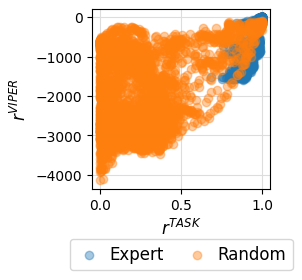

In [41]:
# Visualize correlation between task reward and videogpt reward.
good_rewards = nbu.extract_key_from_seqs(good_seqs, 'reward')
good_densities = nbu.extract_key_from_seqs(good_seqs, 'density')
bad_rewards = nbu.extract_key_from_seqs(bad_seqs, 'reward')
bad_densities = nbu.extract_key_from_seqs(bad_seqs, 'density')

fig, axes = plt.subplots(1, 1, figsize=(2.3, 2.3))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

axes = axes.flatten()

for ax in axes:
    ax.grid(which='both', color='#dddddd')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.tick_params(which='minor', length=0)

axes[0].scatter(good_rewards, good_densities, label='Expert', alpha=0.4, zorder=1000)
axes[0].scatter(bad_rewards, bad_densities, label='Random', alpha=0.4, zorder=1000)
axes[0].set_xlabel(r'$r^{TASK}$', fontsize='large')
axes[0].set_ylabel(r'$r^{VIPER}$', fontsize='large')

options = dict(
    fontsize='large', numpoints=1, labelspacing=0, columnspacing=1.2,
    handlelength=1.5, handletextpad=0.5, ncol=4, loc='lower center', frameon=True, fancybox=True)
plt.legend(bbox_to_anchor=(0.5, -0.5), **options)
plt.ticklabel_format(axis='both', style='sci', scilimits=(2,4))
# plt.suptitle(f'Reward model: {rm_key}')
plt.subplots_adjust(bottom=0.1)
plt.show()

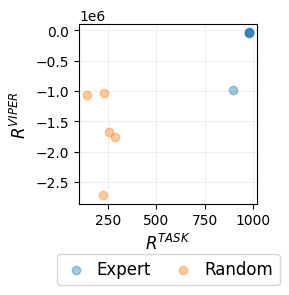

In [47]:
# Visualize correlation between task return and videogpt return.
good_returns = nbu.extract_key_from_seqs(good_seqs, 'reward', reduce=np.sum)
good_densities_returns = nbu.extract_key_from_seqs(good_seqs, 'density', reduce=np.sum)
bad_returns = nbu.extract_key_from_seqs(bad_seqs, 'reward', reduce=np.sum)
bad_densities_returns = nbu.extract_key_from_seqs(bad_seqs, 'density', reduce=np.sum)

fig, axes = plt.subplots(1, 1, figsize=(2.3, 2.3))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

axes = axes.flatten()

for ax in axes:
    ax.grid(which='both', color='#eeeeee')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.tick_params(which='minor', length=0)

axes[0].scatter(good_returns, good_densities_returns, label='Expert', alpha=0.4, zorder=1000)
axes[0].scatter(bad_returns, bad_densities_returns, label='Random', alpha=0.4, zorder=1000)
axes[0].set_xlabel(r'$R^{TASK}$', fontsize='large')
axes[0].set_ylabel(r'$R^{VIPER}$', fontsize='large')

options = dict(
    fontsize='large', numpoints=1, labelspacing=0, columnspacing=1.2,
    handlelength=1.5, handletextpad=0.5, ncol=4, loc='lower center', frameon=True, fancybox=True)
plt.legend(bbox_to_anchor=(0.5, -0.5), **options)
plt.ticklabel_format(axis='both', style='sci', scilimits=(1,4))
# plt.suptitle(f'Reward model: {rm_key}')
plt.subplots_adjust(bottom=0.1)
plt.show()

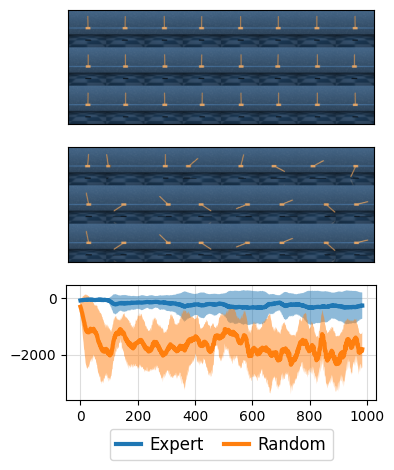

Mean: -228.49961853027344, Std: 383.0308837890625


In [48]:
# Visualize density throughout episode.
good_stack = np.stack([nbu.extract_key_from_seq(seq, 'density') for seq in good_seqs])
bad_stack = np.stack([nbu.extract_key_from_seq(seq, 'density') for seq in bad_seqs])
good_mean, good_std = np.mean(good_stack, axis=0), np.std(good_stack, axis=0)
bad_mean, bad_std = np.mean(bad_stack, axis=0), np.std(bad_stack, axis=0)

fig, axes = plt.subplots(3, 1, figsize=(4.0, 5.0))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

axes = axes.flatten()

for ax in axes:
    ax.grid(which='both', color='#dddddd')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
    ax.tick_params(which='minor', length=0)

axes[2].plot(good_mean, label='Expert', lw=3, zorder=1000)
axes[2].fill_between(np.arange(len(good_mean)), good_mean - good_std, good_mean + good_std, alpha=0.5, zorder=1000 - 1)

axes[2].plot(bad_mean, label='Random', lw=3, zorder=1000)
axes[2].fill_between(np.arange(len(bad_mean)), bad_mean - bad_std, bad_mean + bad_std, alpha=0.5, zorder=1000-1)

plt.subplots_adjust(bottom=0.1)
options = dict(
    fontsize='large', numpoints=1, labelspacing=0, columnspacing=1.2,
    handlelength=1.5, handletextpad=0.5, ncol=4, loc='lower center', frameon=True, fancybox=True)
axes[2].legend(bbox_to_anchor=(0.5, -0.6), **options)


img_rows = nbu.construct_im_rows(good_seqs, reward_model.camera_key, num_eps=3, num_ims=8)
axes[0].imshow(img_rows)
axes[0].set_xticks([])
axes[0].set_yticks([])

img_rows = nbu.construct_im_rows(bad_seqs, reward_model.camera_key, num_eps=3, num_ims=8)
axes[1].imshow(img_rows)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()
print(f'Mean: {np.mean(good_mean)}, Std: {np.mean(good_std)}')

In [49]:

def extract_trajectory_stats(seq, num_ims=8):
    densities = [step['density'] for step in seq]

    # using the variable axs for multiple Axes
    fig, axes = plt.subplots(2, 1, figsize=(7.0, 3.0))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    axes = axes.flatten()

    for ax in axes:
        ax.grid(which='both', color='#dddddd')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(int(1)))
        ax.tick_params(which='minor', length=0)
    

    axes[1].plot(good_mean, '--', label='good traj mean', lw=3, zorder=1000)
    axes[1].plot(bad_mean, '--', label='bad traj mean', lw=3, zorder=1000)
    axes[1].plot(densities, label='traj density', lw=3, zorder=1000)
    axes[1].legend()

    img_row = nbu.construct_im_rows([seq], reward_model.camera_key, num_eps=1, num_ims=num_ims)

    axes[0].imshow(img_row)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0, bottom=0.1)

    options = dict(
    fontsize='large', numpoints=1, labelspacing=0, columnspacing=1.2,
    handlelength=1.5, handletextpad=0.5, ncol=4, loc='lower center', frameon=True, fancybox=True)
    plt.legend(bbox_to_anchor=(0.5, -0.6), **options)
    
    plt.show()


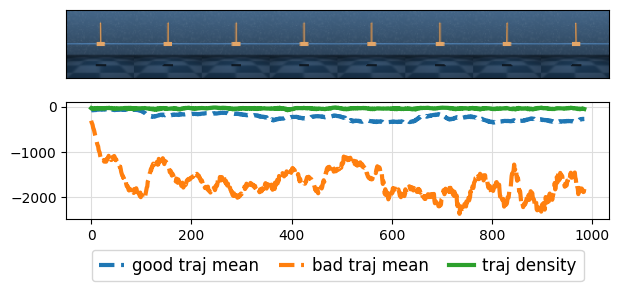

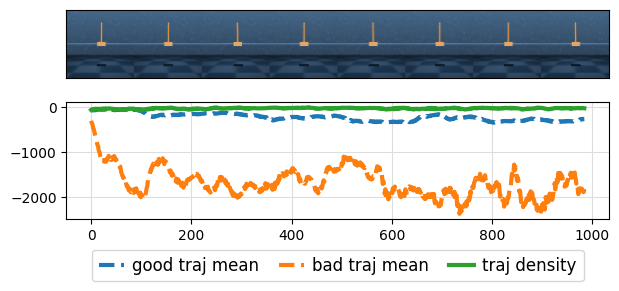

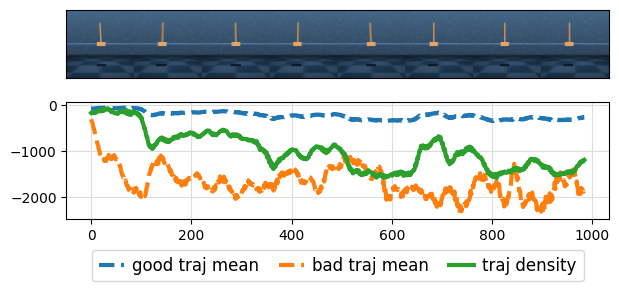

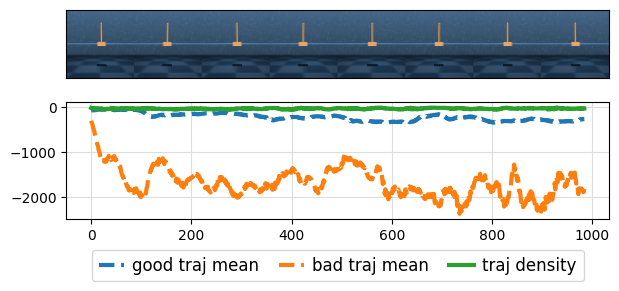

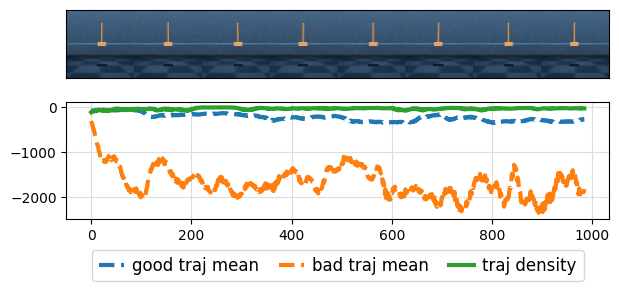

In [50]:
for i in range(len(good_seqs)):
    extract_trajectory_stats(good_seqs[i])

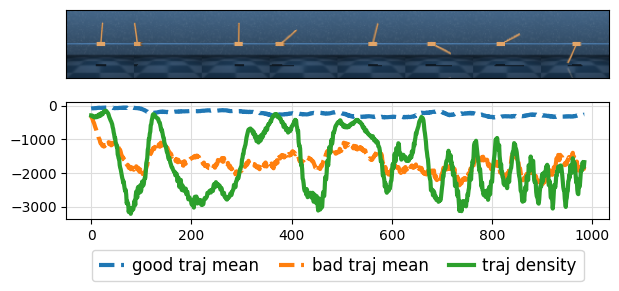

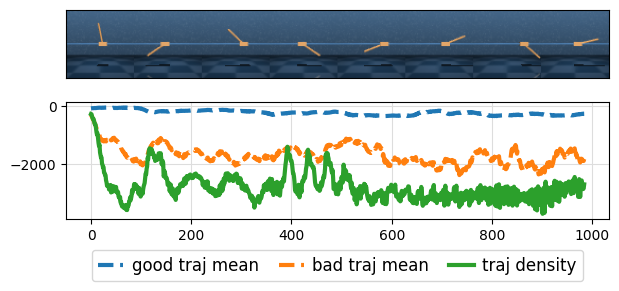

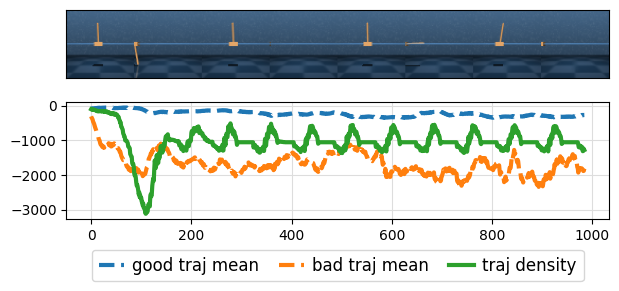

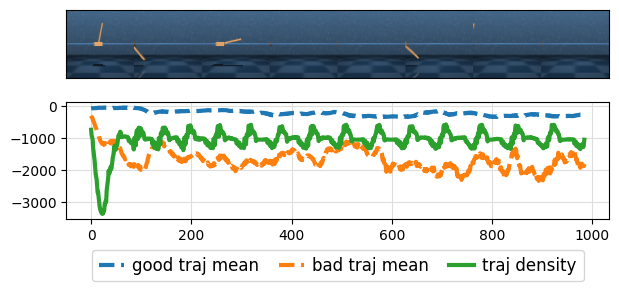

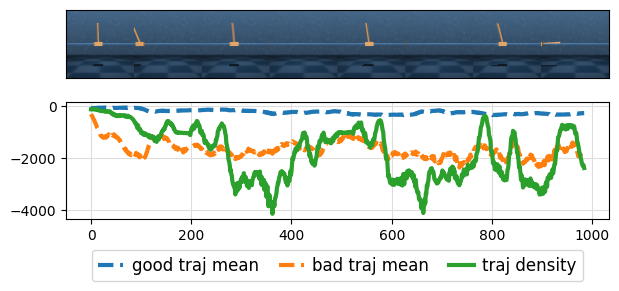

In [46]:
for i in range(len(bad_seqs)):
    extract_trajectory_stats(bad_seqs[i])